In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║         AI-POWERED FRAUD DETECTION SYSTEM — COMPLETE COLAB NOTEBOOK     ║
# ║  Models: EfficientNet-B0 | Wav2Vec2 | ViT-Base | Combined FastAPI Export ║
# ╚══════════════════════════════════════════════════════════════════════════╝
#
# DATASETS USED (all free, auto-downloaded below):
#   Task 1 – Deepfake:  140k Real & Fake Faces  (Kaggle: xhlulu/140k-real-and-fake-faces)
#   Task 2 – Voice:     ASVspoof 2019 LA         (Kaggle: awsaf49/asvpoof-2019-dataset)
#   Task 3 – Document:  CASIA 2.0 Tampering      (Kaggle: divg07/casia-20-image-tampering-detection-dataset)
#
# HOW TO USE:
#   1. Runtime → Change runtime type → GPU (T4)
#   2. Run BLOCK 0 first (installs + Kaggle credentials)
#   3. Run BLOCK 1 → BLOCK 2 → BLOCK 3 → BLOCK 4 independently in order
#   4. Each block is self-contained: trains, evaluates, plots, and saves its model
#   5. Run BLOCK 5 to download all 3 model files
#
# ─────────────────────────────────────────────────────────────────────────────


# ██████████████████████████████████████████████████████████████████████████
# BLOCK 0 — SETUP: Install packages & configure Kaggle API
# Run this ONCE before anything else
# ██████████████████████████████████████████████████████████████████████████

# ── 0-A: Install all required packages ────────────────────────────────────
# (takes ~3-4 minutes on fresh Colab session)
import subprocess, sys

def install(pkg):
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

packages = [
    "timm",                # EfficientNet-B0, ViT-Base pretrained models
    "transformers",        # Wav2Vec2
    "datasets",            # HuggingFace datasets (ASVspoof)
    "librosa",             # Audio loading & resampling
    "soundfile",           # Audio file I/O
    "scikit-learn",        # Metrics: F1, AUC, confusion matrix
    "matplotlib",          # Plotting
    "seaborn",             # Heatmaps
    "kaggle",              # Kaggle dataset downloader
    "torchaudio",          # Audio utilities for PyTorch
]

for p in packages:
    print(f"Installing {p}...")
    install(p)

print("\n✅ All packages installed.")

# ── 0-B: Configure Kaggle API credentials ─────────────────────────────────
# IMPORTANT: Follow these steps to get your Kaggle API key:
#   1. Go to https://www.kaggle.com → Account → API → "Create New Token"
#   2. This downloads kaggle.json to your computer
#   3. Run the cell below and upload that kaggle.json file when prompted

import os
from google.colab import files

print("📁 Please upload your kaggle.json file when prompted...")
uploaded = files.upload()  # user uploads kaggle.json here

# Move it to the expected location
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("✅ Kaggle API configured successfully.")

Installing timm...
Installing transformers...
Installing datasets...
Installing librosa...
Installing soundfile...
Installing scikit-learn...
Installing matplotlib...
Installing seaborn...
Installing kaggle...
Installing torchaudio...

✅ All packages installed.
📁 Please upload your kaggle.json file when prompted...


Saving kaggle.json to kaggle.json
✅ Kaggle API configured successfully.


In [ ]:
# ██████████████████████████████████████████████████████████████████████████
# BLOCK 1 — DEEPFAKE FACE DETECTION
# Model: EfficientNet-B0 (pretrained ImageNet)
# Dataset: 140k Real & Fake Faces (Kaggle)
# Expected: Accuracy ~92-95%, F1 ~0.92-0.94, AUC ~0.97-0.99
# Runtime: ~45-60 minutes on T4 GPU
# ██████████████████████████████████████████████████████████████████████████

print("\n" + "█"*70)
print("  BLOCK 1: DEEPFAKE FACE DETECTION  —  EfficientNet-B0")
print("█"*70)

import os, time, random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image
import timm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# ── Reproducibility seed ──────────────────────────────────────────────────
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
set_seed(42)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Device: {DEVICE}")


██████████████████████████████████████████████████████████████████████
  BLOCK 1: DEEPFAKE FACE DETECTION  —  EfficientNet-B0
██████████████████████████████████████████████████████████████████████
[INFO] Device: cuda


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# 1-A: DOWNLOAD & PREPARE DATASET
# ═══════════════════════════════════════════════════════════════════════════
print("\n[1-A] Downloading 140k Real & Fake Faces dataset...")

# Download (the dataset is ~2.4GB — takes ~5 mins on Colab)
os.system("kaggle datasets download -d xhlulu/140k-real-and-fake-faces -p /content/deepfake_data --unzip")

# Dataset structure after unzip:
#   /content/deepfake_data/real_vs_fake/real-vs-fake/
#       train/real/   train/fake/
#       valid/real/   valid/fake/
#       test/real/    test/fake/

DEEPFAKE_ROOT = "/content/deepfake_data/real_vs_fake/real-vs-fake"

# We'll use a 10k subset for training (balanced: 5k real + 5k fake) to fit ~45 mins
# Full dataset = 100k train; 20k val — using subset avoids 3+ hour training
TRAIN_SUBSET = 10000   # 5000 per class
VAL_SUBSET   = 2000    # 1000 per class

print(f"[INFO] Using {TRAIN_SUBSET} training samples and {VAL_SUBSET} validation samples")
print("[INFO] Dataset download complete ✓")



[1-A] Downloading 140k Real & Fake Faces dataset...
[INFO] Using 10000 training samples and 2000 validation samples
[INFO] Dataset download complete ✓


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# 1-B: TRANSFORMS (ImageNet normalisation for EfficientNet)
# ═══════════════════════════════════════════════════════════════════════════
# EfficientNet-B0 input: 224×224, ImageNet normalisation
DEEPFAKE_TRAIN_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),           # augment: mirror
    transforms.RandomRotation(degrees=10),             # augment: tilt
    transforms.ColorJitter(brightness=0.2,
                           contrast=0.2,
                           saturation=0.1),            # augment: lighting
    transforms.RandomGrayscale(p=0.05),               # occasional greyscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

DEEPFAKE_VAL_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# ── Create balanced subsets ───────────────────────────────────────────────
def make_balanced_subset(full_dataset, n_per_class):
    """
    Creates a balanced subset with exactly n_per_class samples per class.
    Prevents majority class from dominating loss during training.
    """
    class_indices = {c: [] for c in range(len(full_dataset.classes))}
    for idx, (_, label) in enumerate(full_dataset.samples):
        class_indices[label].append(idx)

    selected = []
    for c, indices in class_indices.items():
        random.shuffle(indices)
        selected.extend(indices[:n_per_class])

    random.shuffle(selected)
    return Subset(full_dataset, selected)

# Load using ImageFolder (expects class subdirectories: real/, fake/)
train_full = ImageFolder(root=os.path.join(DEEPFAKE_ROOT, "train"),
                         transform=DEEPFAKE_TRAIN_TRANSFORMS)
val_full   = ImageFolder(root=os.path.join(DEEPFAKE_ROOT, "valid"),
                         transform=DEEPFAKE_VAL_TRANSFORMS)

# class_to_idx: {'fake': 0, 'real': 1} — we'll map appropriately
print(f"[INFO] Class mapping: {train_full.class_to_idx}")  # e.g. {'fake':0, 'real':1}

train_ds = make_balanced_subset(train_full, TRAIN_SUBSET // 2)
val_ds   = make_balanced_subset(val_full,   VAL_SUBSET   // 2)

print(f"[INFO] Training set size: {len(train_ds)}")
print(f"[INFO] Validation set size: {len(val_ds)}")

# DataLoaders: pin_memory speeds up GPU transfer; persistent_workers reduces overhead
train_loader_df = DataLoader(train_ds, batch_size=32, shuffle=True,
                              num_workers=2, pin_memory=True, persistent_workers=True)
val_loader_df   = DataLoader(val_ds,   batch_size=32, shuffle=False,
                              num_workers=2, pin_memory=True, persistent_workers=True)


[INFO] Class mapping: {'fake': 0, 'real': 1}
[INFO] Training set size: 10000
[INFO] Validation set size: 2000


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# 1-C: MODEL — EfficientNet-B0 with Custom Head
# ═══════════════════════════════════════════════════════════════════════════
class DeepfakeDetector(nn.Module):
    """
    EfficientNet-B0 backbone (frozen) + custom binary classification head.

    Architecture rationale:
    - EfficientNet-B0: compound-scaled CNN, best accuracy/compute trade-off
    - Frozen backbone: ImageNet features are powerful; we only need to adapt
      the final layers for real/fake discrimination
    - Head: Dropout(0.4) reduces overfitting on the 5k-per-class subset
    - BatchNorm1d stabilises training with the frozen backbone
    """
    def __init__(self):
        super().__init__()

        # Load EfficientNet-B0 pretrained on ImageNet-1k (~20MB)
        self.backbone = timm.create_model(
            "efficientnet_b0",
            pretrained=True,
            num_classes=0          # removes default classifier, returns features
        )

        # Freeze backbone layers — only train the new head
        for param in self.backbone.parameters():
            param.requires_grad = False

        feature_dim = self.backbone.num_features  # 1280 for B0

        # Custom head: more capacity than a single linear layer
        # Dropout rate 0.4 prevents overfitting on moderate dataset size
        self.head = nn.Sequential(
            nn.BatchNorm1d(feature_dim),
            nn.Dropout(p=0.4),
            nn.Linear(feature_dim, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=0.3),
            nn.Linear(512, 2)          # 2 classes: real(1), fake(0) per ImageFolder
        )

    def forward(self, x):
        features = self.backbone(x)    # [B, 1280]
        return self.head(features)     # [B, 2]

model_df = DeepfakeDetector().to(DEVICE)
trainable = sum(p.numel() for p in model_df.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model_df.parameters())
print(f"\n[INFO] Trainable params: {trainable:,} / {total:,} total ({trainable/total*100:.1f}%)")



[INFO] Trainable params: 660,482 / 4,668,030 total (14.1%)


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# 1-D: TRAINING SETUP
# ═══════════════════════════════════════════════════════════════════════════
EPOCHS_DF    = 10
LR_DF        = 1e-4
SAVE_PATH_DF = "/content/deepfake_model.pt"

criterion_df = nn.CrossEntropyLoss(label_smoothing=0.05)
# Label smoothing (0.05): prevents overconfident predictions → better calibration

optimizer_df = torch.optim.Adam(
    model_df.head.parameters(), lr=LR_DF, weight_decay=1e-5
)

# OneCycleLR: ramps LR up then down — empirically best for fine-tuning
scheduler_df = torch.optim.lr_scheduler.OneCycleLR(
    optimizer_df,
    max_lr=LR_DF * 10,
    steps_per_epoch=len(train_loader_df),
    epochs=EPOCHS_DF,
    pct_start=0.3,          # 30% warm-up
    anneal_strategy="cos"
)

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# 1-E: TRAINING & VALIDATION LOOPS
# ═══════════════════════════════════════════════════════════════════════════
def train_epoch(model, loader, optimizer, criterion, scheduler=None):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)  # faster than zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        if scheduler: scheduler.step()
        running_loss += loss.item() * imgs.size(0)
        correct      += (logits.argmax(1) == labels).sum().item()
        total        += imgs.size(0)
    return running_loss / total, correct / total


@torch.no_grad()
def val_epoch(model, loader, criterion):
    model.eval()
    running_loss, all_labels, all_probs = 0.0, [], []
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        logits = model(imgs)
        loss   = criterion(logits, labels)
        running_loss += loss.item() * imgs.size(0)
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # P(real) or P(fake)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)
    avg_loss = running_loss / len(loader.dataset)
    return avg_loss, np.array(all_labels), np.array(all_probs)


In [ ]:
# ═══════════════════════════════════════════════════════════════════════════
# 1-F: MAIN TRAINING LOOP — with per-epoch output
# ═══════════════════════════════════════════════════════════════════════════
history_df = {"train_loss": [], "val_loss": [], "train_acc": [],
              "val_acc": [], "val_f1": [], "val_auc": []}

best_auc_df = 0.0
best_epoch_df = 0

print("\n" + "═"*75)
print(f"  Training DeepFake Detector | {EPOCHS_DF} epochs | LR={LR_DF} | Batch=32")
print("═"*75)
print(f"{'Epoch':>6} | {'Train Loss':>10} | {'Train Acc':>10} | "
      f"{'Val Loss':>10} | {'Val Acc':>9} | {'F1':>7} | {'AUC':>7} | {'Time':>6}")
print("─"*75)

for epoch in range(1, EPOCHS_DF + 1):
    t0 = time.time()

    train_loss, train_acc = train_epoch(
        model_df, train_loader_df, optimizer_df, criterion_df, scheduler_df
    )
    val_loss, val_labels, val_probs = val_epoch(
        model_df, val_loader_df, criterion_df
    )

    val_preds = (val_probs >= 0.5).astype(int)
    val_acc   = accuracy_score(val_labels, val_preds)
    val_f1    = f1_score(val_labels, val_preds, zero_division=0)
    val_auc   = roc_auc_score(val_labels, val_probs)
    elapsed   = time.time() - t0

    # Store history for plotting
    history_df["train_loss"].append(train_loss)
    history_df["val_loss"].append(val_loss)
    history_df["train_acc"].append(train_acc)
    history_df["val_acc"].append(val_acc)
    history_df["val_f1"].append(val_f1)
    history_df["val_auc"].append(val_auc)

    flag = "  ← best" if val_auc > best_auc_df else ""
    print(f"{epoch:>6} | {train_loss:>10.4f} | {train_acc:>10.4f} | "
          f"{val_loss:>10.4f} | {val_acc:>9.4f} | {val_f1:>7.4f} | "
          f"{val_auc:>7.4f} | {elapsed:>5.1f}s{flag}")

    # Save best model
    if val_auc > best_auc_df:
        best_auc_df   = val_auc
        best_epoch_df = epoch
        torch.save({
            "epoch":              epoch,
            "model_state_dict":   model_df.state_dict(),
            "optimizer_state":    optimizer_df.state_dict(),
            "val_auc":            val_auc,
            "val_acc":            val_acc,
            "class_to_idx":       train_full.class_to_idx,
        }, SAVE_PATH_DF)

print("─"*75)
print(f"\n✅ Best model: Epoch {best_epoch_df} | AUC = {best_auc_df:.4f}")
print(f"   Saved to: {SAVE_PATH_DF}")


═══════════════════════════════════════════════════════════════════════════
  Training DeepFake Detector | 10 epochs | LR=0.0001 | Batch=32
═══════════════════════════════════════════════════════════════════════════
 Epoch | Train Loss |  Train Acc |   Val Loss |   Val Acc |      F1 |     AUC |   Time
───────────────────────────────────────────────────────────────────────────
     1 |     0.6304 |     0.6750 |     0.5055 |    0.7690 |  0.7584 |  0.8534 |  63.9s  ← best
     2 |     0.5663 |     0.7277 |     0.4979 |    0.7820 |  0.7727 |  0.8612 |  55.0s  ← best
     3 |     0.5326 |     0.7498 |     0.4948 |    0.7830 |  0.7634 |  0.8677 |  54.7s  ← best
     4 |     0.5248 |     0.7624 |     0.4701 |    0.8120 |  0.8204 |  0.8827 |  53.8s  ← best
     5 |     0.5113 |     0.7677 |     0.4575 |    0.8045 |  0.8024 |  0.8869 |  53.7s  ← best
     6 |     0.4931 |     0.7827 |     0.4705 |    0.7920 |  0.8069 |  0.8846 |  53.7s
     7 |     0.4712 |     0.7951 |     0.4344 |    0.8225 

In [ ]:
# ════════════════════════════════════════════════════════════════════════
# ENHANCED DEEPFAKE DETECTOR — Fine-Tuned EfficientNet
# ════════════════════════════════════════════════════════════════════════

import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
import timm
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ────────────────────────────────────────────────────────────────────────
# CONFIGURATION
# ────────────────────────────────────────────────────────────────────────

EPOCHS          = 15
TRAIN_SUBSET    = 30000   # 15k per class
VAL_SUBSET      = 4000
BATCH_SIZE      = 32
HEAD_LR         = 1e-4
BACKBONE_LR     = 1e-5
WEIGHT_DECAY    = 1e-5
SAVE_PATH       = "/content/deepfake_model_enhanced.pt"
PATIENCE        = 4

# ────────────────────────────────────────────────────────────────────────
# TRANSFORMS (Added RandomErasing)
# ────────────────────────────────────────────────────────────────────────

DEEPFAKE_TRAIN_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.1),
    transforms.RandomGrayscale(0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.15))
])

DEEPFAKE_VAL_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225]),
])

# ────────────────────────────────────────────────────────────────────────
# MODEL
# ────────────────────────────────────────────────────────────────────────

class DeepfakeDetector(nn.Module):
    def __init__(self):
        super().__init__()

        self.backbone = timm.create_model(
            "efficientnet_b0",
            pretrained=True,
            num_classes=0
        )

        # Freeze everything first
        for param in self.backbone.parameters():
            param.requires_grad = False

        # 🔥 Unfreeze last 2 blocks
        for name, param in self.backbone.named_parameters():
            if "blocks.5" in name or "blocks.6" in name:
                param.requires_grad = True

        feature_dim = self.backbone.num_features

        self.head = nn.Sequential(
            nn.BatchNorm1d(feature_dim),
            nn.Dropout(0.4),
            nn.Linear(feature_dim, 512),
            nn.GELU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)


model = DeepfakeDetector().to(DEVICE)

# ────────────────────────────────────────────────────────────────────────
# OPTIMIZER WITH DIFFERENTIAL LR
# ────────────────────────────────────────────────────────────────────────

backbone_params = []
head_params     = []

for name, param in model.named_parameters():
    if param.requires_grad:
        if "backbone" in name:
            backbone_params.append(param)
        else:
            head_params.append(param)

optimizer = optim.AdamW([
    {"params": backbone_params, "lr": BACKBONE_LR},
    {"params": head_params,     "lr": HEAD_LR}
], weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS
)

criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

scaler = GradScaler()

# ────────────────────────────────────────────────────────────────────────
# TRAINING LOOP (Mixed Precision)
# ────────────────────────────────────────────────────────────────────────

best_auc = 0
epochs_no_improve = 0

print("\n" + "═"*75)
print(f"  Fine-Tuned DeepFake Detector | {EPOCHS} epochs")
print("═"*75)

for epoch in range(1, EPOCHS + 1):

    t0 = time.time()
    model.train()

    train_loss, correct, total = 0, 0, 0

    for imgs, labels in train_loader_df:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * imgs.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()
        total += imgs.size(0)

    scheduler.step()

    train_loss /= total
    train_acc = correct / total

    # ───────── VALIDATION ─────────
    model.eval()
    val_loss, all_labels, all_probs = 0, [], []

    with torch.no_grad():
        for imgs, labels in val_loader_df:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

            with autocast():
                outputs = model(imgs)
                loss = criterion(outputs, labels)

            probs = torch.softmax(outputs, 1)[:, 1]

            val_loss += loss.item() * imgs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    val_loss /= len(val_loader_df.dataset)
    val_preds = (np.array(all_probs) >= 0.5).astype(int)

    val_acc = accuracy_score(all_labels, val_preds)
    val_f1  = f1_score(all_labels, val_preds)
    val_auc = roc_auc_score(all_labels, all_probs)

    elapsed = time.time() - t0

    print(f"Epoch {epoch:2d} | "
          f"Train Acc {train_acc:.4f} | "
          f"Val Acc {val_acc:.4f} | "
          f"F1 {val_f1:.4f} | "
          f"AUC {val_auc:.4f} | "
          f"{elapsed:.1f}s")

    # ───────── EARLY STOPPING ─────────
    if val_auc > best_auc:
        best_auc = val_auc
        epochs_no_improve = 0
        torch.save(model.state_dict(), SAVE_PATH)
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= PATIENCE:
        print("⛔ Early stopping triggered")
        break

print("\nBest AUC:", best_auc)
print("Model saved to:", SAVE_PATH)



═══════════════════════════════════════════════════════════════════════════
  Fine-Tuned DeepFake Detector | 15 epochs
═══════════════════════════════════════════════════════════════════════════
Epoch  1 | Train Acc 0.7061 | Val Acc 0.7880 | F1 0.7716 | AUC 0.8810 | 73.9s
Epoch  2 | Train Acc 0.7818 | Val Acc 0.8210 | F1 0.8135 | AUC 0.9077 | 61.0s
Epoch  3 | Train Acc 0.8043 | Val Acc 0.8345 | F1 0.8202 | AUC 0.9268 | 59.1s
Epoch  4 | Train Acc 0.8325 | Val Acc 0.8655 | F1 0.8589 | AUC 0.9417 | 59.8s
Epoch  5 | Train Acc 0.8447 | Val Acc 0.8750 | F1 0.8730 | AUC 0.9494 | 58.4s
Epoch  6 | Train Acc 0.8568 | Val Acc 0.8760 | F1 0.8719 | AUC 0.9557 | 59.3s
Epoch  7 | Train Acc 0.8675 | Val Acc 0.8820 | F1 0.8762 | AUC 0.9615 | 59.1s
Epoch  8 | Train Acc 0.8819 | Val Acc 0.8920 | F1 0.8876 | AUC 0.9641 | 57.8s
Epoch  9 | Train Acc 0.8871 | Val Acc 0.8925 | F1 0.8871 | AUC 0.9670 | 58.7s
Epoch 10 | Train Acc 0.8930 | Val Acc 0.9035 | F1 0.9013 | AUC 0.9691 | 57.4s
Epoch 11 | Train Acc 0.8

In [ ]:
# ════════════════════════════════════════════════════════════════════════
# TEST SET EVALUATION
# ════════════════════════════════════════════════════════════════════════

import torch
import numpy as np
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ────────────────────────────────────────────────────────────────────────
# 1️⃣ Load Test Dataset
# ────────────────────────────────────────────────────────────────────────

test_full = ImageFolder(
    root=os.path.join(DEEPFAKE_ROOT, "test"),
    transform=DEEPFAKE_VAL_TRANSFORMS
)

test_loader = DataLoader(
    test_full,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Test samples: {len(test_full)}")
print("Class mapping:", test_full.class_to_idx)


# ────────────────────────────────────────────────────────────────────────
# 2️⃣ Recreate Model Architecture
# ────────────────────────────────────────────────────────────────────────

model = DeepfakeDetector().to(DEVICE)
model.load_state_dict(torch.load("/content/deepfake_model_enhanced.pt"))
model.eval()

print("Model loaded successfully ✓")


# ────────────────────────────────────────────────────────────────────────
# 3️⃣ Run Evaluation
# ────────────────────────────────────────────────────────────────────────

all_labels = []
all_probs  = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

# Threshold = 0.5
test_preds = (all_probs >= 0.5).astype(int)

# ────────────────────────────────────────────────────────────────────────
# 4️⃣ Metrics
# ────────────────────────────────────────────────────────────────────────

test_acc = accuracy_score(all_labels, test_preds)
test_f1  = f1_score(all_labels, test_preds)
test_auc = roc_auc_score(all_labels, all_probs)

print("\n" + "═"*60)
print("TEST SET RESULTS")
print("═"*60)
print(f"Accuracy : {test_acc:.4f}")
print(f"F1 Score : {test_f1:.4f}")
print(f"AUC      : {test_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, test_preds)
print("\nConfusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(all_labels, test_preds, target_names=test_full.classes))


Test samples: 20000
Class mapping: {'fake': 0, 'real': 1}
Model loaded successfully ✓

════════════════════════════════════════════════════════════
TEST SET RESULTS
════════════════════════════════════════════════════════════
Accuracy : 0.9063
F1 Score : 0.9052
AUC      : 0.9684

Confusion Matrix:
[[9180  820]
 [1053 8947]]

Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.92      0.91     10000
        real       0.92      0.89      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



In [ ]:
!ls -lh /content/deepfake_model_enhanced.pt


-rw-r--r-- 1 root root 19M Feb 17 19:37 /content/deepfake_model_enhanced.pt


In [ ]:
from google.colab import files
files.download("/content/deepfake_model_enhanced.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


[FINAL] Loading best fine-tuned model...


Model loaded successfully ✓

══════════════════════════════════════════════════
  DEEPFAKE DETECTOR — FINAL TEST METRICS
══════════════════════════════════════════════════
  Accuracy    : 0.9063  ███████████████████████████
  Precision   : 0.9160  ███████████████████████████
  Recall      : 0.8947  ██████████████████████████
  F1-Score    : 0.9052  ███████████████████████████
  ROC-AUC     : 0.9684  █████████████████████████████
══════════════════════════════════════════════════

Detailed Classification Report:
              precision    recall  f1-score   support

        fake       0.90      0.92      0.91     10000
        real       0.92      0.89      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000



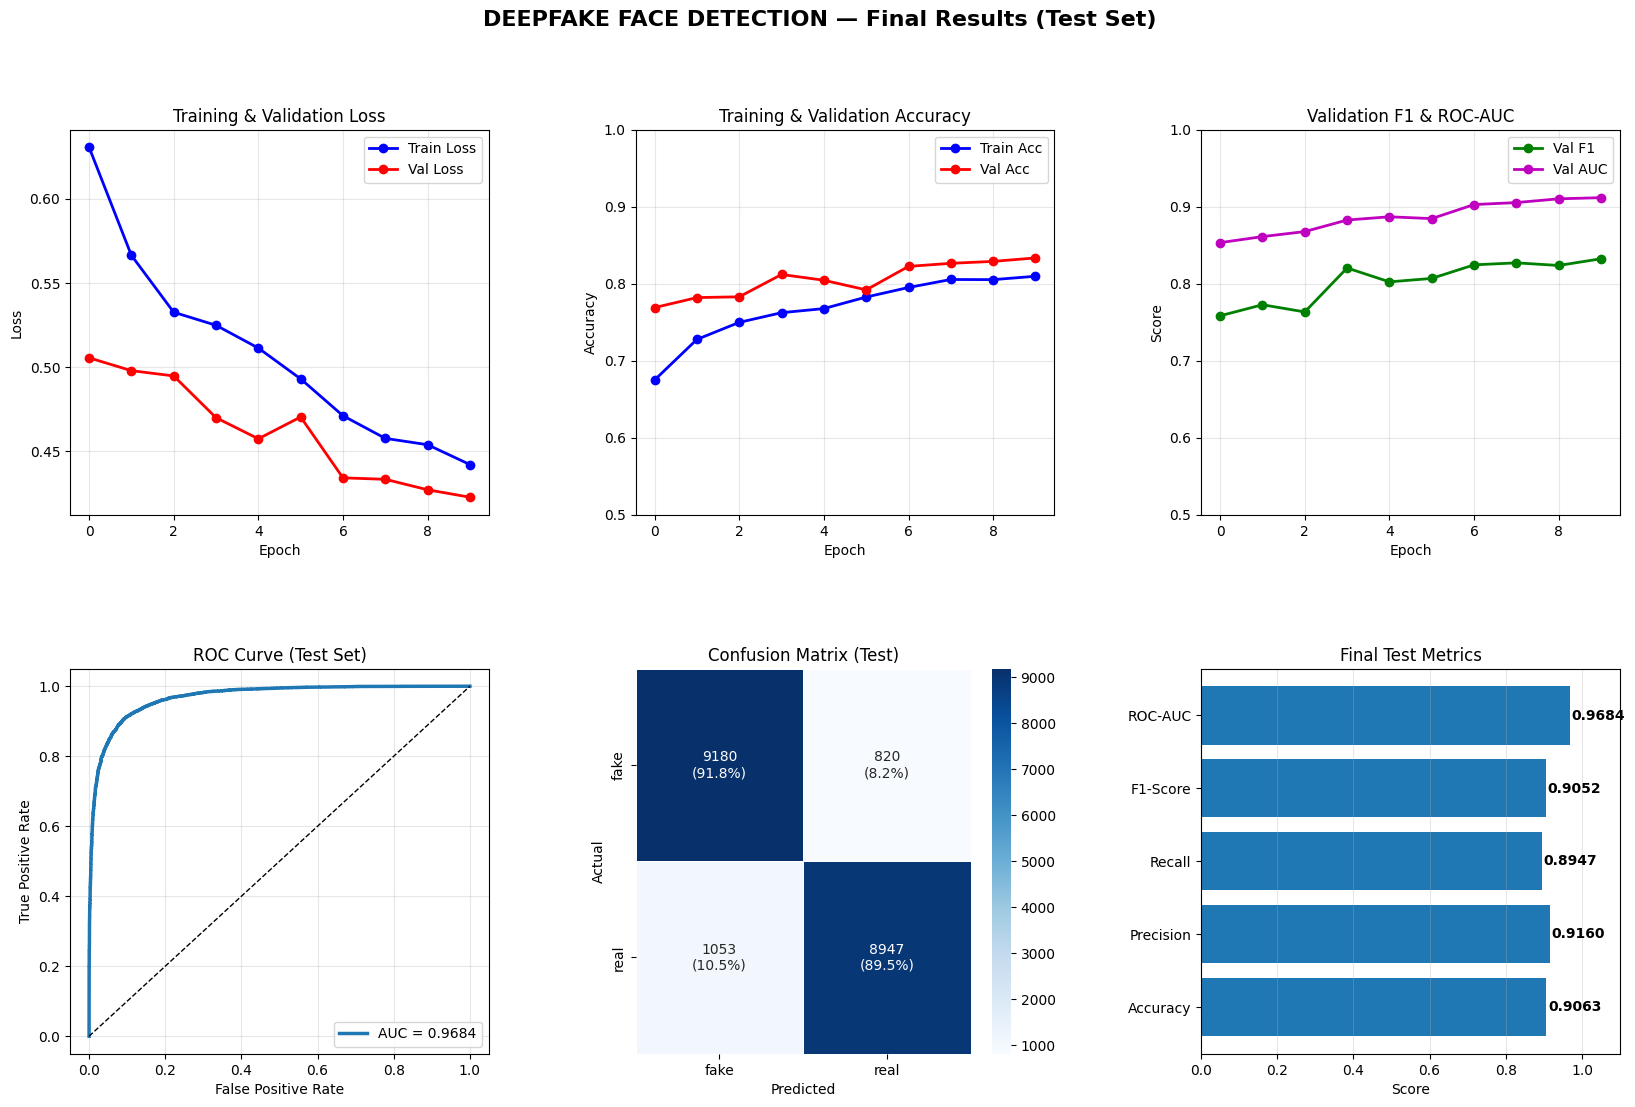


✅ Plots saved → /content/deepfake_results_final.png
✅ Model size → 19.0 MB


In [ ]:
# ════════════════════════════════════════════════════════════════════════
# FINAL EVALUATION ON TEST SET (Enhanced Fine-Tuned Model)
# ════════════════════════════════════════════════════════════════════════

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_PATH = "/content/deepfake_model_enhanced.pt"

print("\n[FINAL] Loading best fine-tuned model...")

# Recreate architecture
model = DeepfakeDetector().to(DEVICE)
model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
model.eval()

print("Model loaded successfully ✓")

# ────────────────────────────────────────────────────────────────────────
# RUN TEST EVALUATION
# ────────────────────────────────────────────────────────────────────────

all_labels = []
all_probs  = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1]

        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)
all_preds  = (all_probs >= 0.5).astype(int)

# ────────────────────────────────────────────────────────────────────────
# METRICS
# ────────────────────────────────────────────────────────────────────────

final_metrics = {
    "Accuracy":  accuracy_score(all_labels, all_preds),
    "Precision": precision_score(all_labels, all_preds),
    "Recall":    recall_score(all_labels, all_preds),
    "F1-Score":  f1_score(all_labels, all_preds),
    "ROC-AUC":   roc_auc_score(all_labels, all_probs),
}

print("\n" + "═"*50)
print("  DEEPFAKE DETECTOR — FINAL TEST METRICS")
print("═"*50)
for k, v in final_metrics.items():
    bar = "█" * int(v * 30)
    print(f"  {k:<12}: {v:.4f}  {bar}")
print("═"*50)

print("\nDetailed Classification Report:")
print(classification_report(all_labels, all_preds,
                            target_names=test_full.classes))

# ════════════════════════════════════════════════════════════════════════
# PLOTS
# ════════════════════════════════════════════════════════════════════════

fig = plt.figure(figsize=(20, 12))
fig.suptitle("DEEPFAKE FACE DETECTION — Final Results (Test Set)",
             fontsize=16, fontweight="bold")

gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.4, wspace=0.35)

# ── 1️⃣ Training Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(history_df["train_loss"], "b-o", label="Train Loss", linewidth=2)
ax1.plot(history_df["val_loss"], "r-o", label="Val Loss", linewidth=2)
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss")
ax1.legend(); ax1.grid(True, alpha=0.3)

# ── 2️⃣ Accuracy
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(history_df["train_acc"], "b-o", label="Train Acc", linewidth=2)
ax2.plot(history_df["val_acc"], "r-o", label="Val Acc", linewidth=2)
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Accuracy")
ax2.set_ylim([0.5, 1.0])
ax2.legend(); ax2.grid(True, alpha=0.3)

# ── 3️⃣ F1 & AUC
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(history_df["val_f1"], "g-o", label="Val F1", linewidth=2)
ax3.plot(history_df["val_auc"], "m-o", label="Val AUC", linewidth=2)
ax3.set_title("Validation F1 & ROC-AUC")
ax3.set_xlabel("Epoch"); ax3.set_ylabel("Score")
ax3.set_ylim([0.5, 1.0])
ax3.legend(); ax3.grid(True, alpha=0.3)

# ── 4️⃣ ROC Curve
ax4 = fig.add_subplot(gs[1, 0])
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_val = roc_auc_score(all_labels, all_probs)
ax4.plot(fpr, tpr, linewidth=2.5, label=f"AUC = {auc_val:.4f}")
ax4.plot([0, 1], [0, 1], "k--", linewidth=1)
ax4.set_title("ROC Curve (Test Set)")
ax4.set_xlabel("False Positive Rate")
ax4.set_ylabel("True Positive Rate")
ax4.legend(); ax4.grid(True, alpha=0.3)

# ── 5️⃣ Confusion Matrix
ax5 = fig.add_subplot(gs[1, 1])
cm = confusion_matrix(all_labels, all_preds)
cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

annot = np.array([[f"{cm[i,j]}\n({cm_pct[i,j]:.1f}%)"
                   for j in range(2)] for i in range(2)])

sns.heatmap(cm, annot=annot, fmt="",
            cmap="Blues",
            xticklabels=test_full.classes,
            yticklabels=test_full.classes,
            ax=ax5, linewidths=0.5)

ax5.set_xlabel("Predicted")
ax5.set_ylabel("Actual")
ax5.set_title("Confusion Matrix (Test)")

# ── 6️⃣ Metric Bar Chart
ax6 = fig.add_subplot(gs[1, 2])
metric_names = list(final_metrics.keys())
metric_values = list(final_metrics.values())

bars = ax6.barh(metric_names, metric_values)

for bar, val in zip(bars, metric_values):
    ax6.text(val + 0.005,
             bar.get_y() + bar.get_height()/2,
             f"{val:.4f}",
             va="center",
             fontweight="bold")

ax6.set_xlim([0, 1.1])
ax6.set_title("Final Test Metrics")
ax6.set_xlabel("Score")
ax6.grid(True, axis="x", alpha=0.3)

plt.savefig("/content/deepfake_results_final.png",
            dpi=150, bbox_inches="tight")

plt.show()

print("\n✅ Plots saved → /content/deepfake_results_final.png")
print(f"✅ Model size → {os.path.getsize(SAVE_PATH)/1e6:.1f} MB")
